In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pylab import *

In [3]:
df= pd.read_pickle("../data/clean_rows_df.pkl")  
df.head()

,VoltageCurve,CurrentCurve,spotName
TimeStamp,,,
2019-11-07 12:29:06,"[132, 744, 1299, 1663, 1894, 2002, 2068, 2110,...","[311, 1990, 3577, 4759, 5599, 6190, 6594, 6999...",60000_0_00
2019-11-07 12:29:26,"[136, 752, 1308, 1675, 1923, 2068, 2128, 2180,...","[301, 1961, 3470, 4527, 5432, 6066, 6489, 6911...",60000_0_00
2019-11-07 12:29:26,"[139, 757, 1292, 1655, 1885, 2042, 2099, 2099,...","[333, 2058, 3663, 4814, 5661, 6388, 6842, 7084...",60000_0_00
2019-11-07 12:29:30,"[133, 743, 1286, 1645, 1887, 2046, 2104, 2104,...","[307, 2031, 3632, 4802, 5695, 6434, 6865, 7142...",60000_0_00
2019-11-07 12:29:32,"[137, 755, 1313, 1683, 1906, 2043, 2147, 2189,...","[302, 1995, 3508, 4596, 5382, 5987, 6562, 6955...",60000_0_00


In [4]:
#Voltage_df=df.drop("CurrentCurve", axis=1)
#Current_df=df.drop("VoltageCurve", axis=1)

In [5]:
df.reset_index(inplace=True)
df.set_index(["spotName","TimeStamp"],inplace=True)

In [6]:
exploded_voltage=pd.DataFrame(df.VoltageCurve.tolist(), index= df.index)

In [7]:
#quali dati hanno la massima numerosità (624) di raccolte
#exploded_voltage[exploded_voltage[623].notna()].head()
#per selezionare la prima riga
#exploded_voltage.iloc[0]
#oppure
#exploded_voltage.loc[("60000_0_00","2019-11-07 12:29:06")]

## Analisi sui valori della tensione
Da grafico delle slide (da ricreare) si nota come molte curve abbiano un calo improvviso: andremo a cercare di identificare tali curve

<AxesSubplot:>

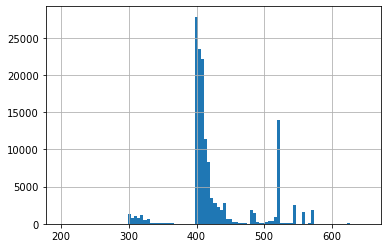

In [8]:
exploded_voltage.count(axis=1).hist(bins=20,range=(200,650))

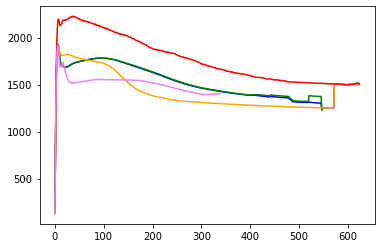

In [9]:
#plotto la curva media di tutti i valori
plot(exploded_voltage.mean(axis=0),"blue")
#plotto la curva media delle sole curve con meno di 500 rilevazioni
plot(exploded_voltage[exploded_voltage.count(axis=1)<550].mean(axis=0),"green")
#plotto la curva media delle sole curve con più di 500 rilevazioni
plot(exploded_voltage[exploded_voltage.count(axis=1)>550].mean(axis=0),"orange")
#plotto la curva media delle sole curve con più di 600 rilevazioni
plot(exploded_voltage[exploded_voltage.count(axis=1)>600].mean(axis=0),"red")
#plotto la curva media delle sole curve con più di 600 rilevazioni
plot(exploded_voltage[exploded_voltage.count(axis=1)<340].mean(axis=0),"violet")

# Approccio statistico

Voglio identificare, attraverso un approccio statistico del differenziale, quelle curve che hanno avuto un picco (o un calo) improvviso della tensione, per cui risulta un anomalia strutturale della curva stessa.

Attraverso diversi tentativi e verifiche grafiche si è optato per un differenziale di quinto ordine.

In [10]:
#calcolo il differenziale di quinto ordine tra valori successivi 
voltage_lag5=exploded_voltage.diff(periods=5,axis=1)
#voltage_lag5.mean(axis=0).head(20)

DA RIVEDERE IL 4*x.std()

In [11]:
#creazione upper e lower limit con uso di mean e deviazion standard (mean +- 4*std)
upper_lag=voltage_lag5.apply(lambda x : x.mean()+4*x.std(),axis=0)
lower_lag=voltage_lag5.apply(lambda x : x.mean()-4*x.std(),axis=0)
#creazione upper e lower usando i quantili
upper_lag2=voltage_lag5.apply(lambda x : x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)
lower_lag2=voltage_lag5.apply(lambda x : x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)

Identificazione dei dati che mostrano un calo o un picco della tensione

In [12]:
#per poter verificare se i valori rientrano o meno nelle soglie stabilite devo trattare i Null:
#sostituisco i Null in voltage_lag5 con 0 
voltage_lag5=voltage_lag5.fillna(0)

#sostituisco i Null in upper_lag con 500
upper_lag=upper_lag.fillna(500)
#sostituisco i Null in lower_lag con -500
lower_lag=lower_lag.fillna(-500)

In [14]:
#creo la colonna voltage_drop per segnalare se nella curva c'è stato un calo di tensione
exploded_voltage["voltage_drop"]=voltage_lag5.apply(lambda x : any(x<lower_lag),axis=1)
#creo la colonna voltage_drop per segnalare se nella curva c'è stato un picco di tensione
exploded_voltage["voltage_spike"]=voltage_lag5.apply(lambda x : any(x>upper_lag),axis=1)

In [65]:
#creo voltage_drops con solo curve con cali di tensione
voltage_drops=exploded_voltage[exploded_voltage["voltage_drop"]==True]
voltage_drops=voltage_drops.drop(["voltage_drop","voltage_spike"],axis=1)

In [63]:
##creo voltage_spikes con solo curve con picchi di tensione
voltage_spikes=exploded_voltage[exploded_voltage["voltage_spike"]==True]
voltage_spikes=voltage_spikes.drop(["voltage_drop","voltage_spike"],axis=1)

Esempio di detection di un calo anomalo della tensione

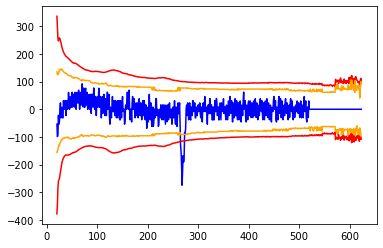

In [41]:
# plot dei differenziali e relativi range di ammissibilità
plt.plot(upper_lag[20:],"red")
plt.plot(upper_lag2[20:],"orange")
plot(voltage_lag5[any(voltage_lag5<lower_lag,axis=1)].iloc[1][20:],"blue")
plt.plot(lower_lag2[20:],"orange")
plt.plot(lower_lag[20:],"red")

In [ ]:
# plot dei differenziali e relativi range di ammissibilità
#plt.plot(upper_lag[20:],"red")
#plt.plot(upper_lag2[20:],"orange")
#plt.plot(voltage_lag5.iloc[20][20:],"blue")
#plt.plot(lower_lag2[20:],"orange")
#plt.plot(lower_lag[20:],"red")

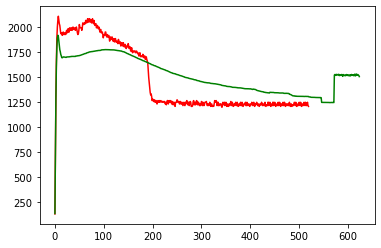

In [42]:
#curva con picco in rosso
plot(voltage_drops.iloc[0],"red")
#curva media tra tutti i dati in verde
plt.plot(exploded_voltage.iloc[: , :624].median(axis=0),"green")

Esempio di detection di un picco anomalo della tensione

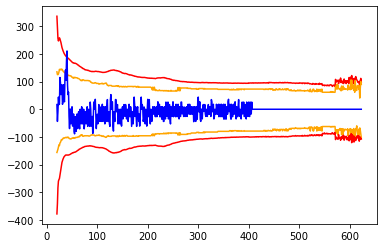

In [50]:
plt.plot(upper_lag[20:],"red")
plt.plot(upper_lag2[20:],"orange")
plot(voltage_lag5[any(voltage_lag5>upper_lag,axis=1)].iloc[1][20:],"blue")
plt.plot(lower_lag2[20:],"orange")
plt.plot(lower_lag[20:],"red")

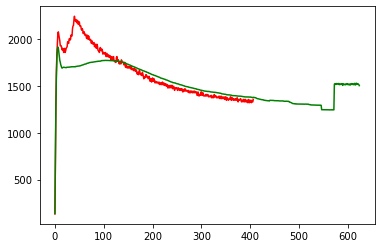

In [51]:
#curva con picco in rosso
plot(voltage_spikes.iloc[1],"red")
#curva media tra tutti i dati in verde
#plt.plot(voltage_no_drops.median(axis=0),"blue")
plt.plot(exploded_voltage.iloc[: , :624].median(axis=0),"green")

Esempio di curva che presenta sia un picco che un calo anomalo della tensione

In [66]:
#creo both_anomalies, dataframe in cui le curve hanno sia un picco che un calo in tensione
both_anomalies=exploded_voltage[(exploded_voltage["voltage_drop"]==True) & (exploded_voltage["voltage_spike"]==True)]
both_anomalies=both_anomalies.drop(["voltage_drop","voltage_spike"],axis=1)
len(both_anomalies)

713

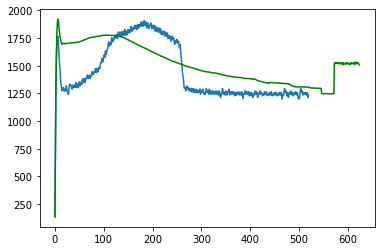

In [70]:
plot(both_anomalies.iloc[2])
plt.plot(exploded_voltage.iloc[: , :624].median(axis=0),"green")

In [52]:
#aggiungo la colonna voltage_drop e voltage_spike al df originale
df=df.join(exploded_voltage[["voltage_drop","voltage_spike"]],how="left")

In [53]:
df.head()

VoltageCurve  \
spotName   TimeStamp                                                                
60000_0_00 2019-09-17 17:56:02  [139, 752, 1329, 1687, 1897, 2037, 2098, 2107,...   
           2019-09-17 17:56:07  [134, 755, 1309, 1661, 1888, 2056, 2140, 2140,...   
           2019-09-17 18:05:02  [134, 758, 1298, 1652, 1897, 2065, 2124, 2124,...   
           2019-09-17 18:42:46  [138, 767, 1328, 1682, 1906, 2061, 2139, 2148,...   
           2019-09-17 18:59:36  [130, 745, 1300, 1646, 1854, 2028, 2114, 2114,...   

                                                                     CurrentCurve  \
spotName   TimeStamp                                                                
60000_0_00 2019-09-17 17:56:02  [302, 1999, 3574, 4694, 5512, 6148, 6542, 6815...   
           2019-09-17 17:56:07  [303, 2002, 3549, 4702, 5551, 6340, 6886, 7189...   
           2019-09-17 18:05:02  [305, 2017, 3607, 4738, 5656, 6389, 6848, 7154...   
           2019-09-17 18:42:46  [333, 2033, 3641, 4795, 5614, 6312, 6767, 7040...   
           2019-09-17 18:59:36  [302, 1996, 3569, 4719, 5536, 6262, 6837, 7109...   

                                voltage_drop  voltage_spike  
spotName   TimeStamp                                         
60000_0_00 2019-09-17 17:56:02         False          False  
           2019-09-17 17:56:07         False          False  
           2019-09-17 18:05:02         False          False  
           2019-09-17 18:42:46         False          False  
           2019-09-17 18:59:36         False          False

## Anomaly detection per singoli punti
Non conosciamo la distribuzione che i dati assumono nei vari istanti temporali (anche se data la numerosità potremmo assumere una distribuzione normale). Definiamo gli outlier come:
-   The data points which fall below mean-3*(sigma) or above mean+3*(sigma) [adatta a norm]
-   The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR [adatta per dist asimettriche]

In [32]:
#creazione upper e lower limit come per Normale (mean +- 2*std:al 95%,mean +- 3*std:al 99% )
upper_limit=exploded_voltage.apply(lambda x : x.mean()+2*x.std(),axis=0)
lower_limit=exploded_voltage.apply(lambda x : x.mean()-2*x.std(),axis=0)

In [33]:
#creazione upper e lower usando i quantili
upper_limit2=exploded_voltage.apply(lambda x : x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)
lower_limit2=exploded_voltage.apply(lambda x : x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)

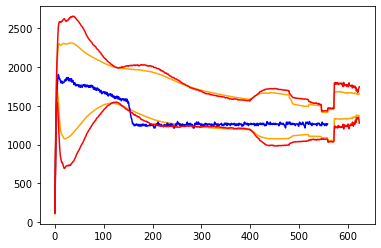

In [36]:
#plottiamo i limiti per vedere come si comportano (in arancio limiti con la std, in rosso con i percentili)
plot(upper_limit,"orange")
plot(lower_limit,"orange")
plot(exploded_voltage.iloc[590],"blue")
plot(upper_limit2,"red")
plot(lower_limit2,"red")